In [5]:
import openpyxl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
import datetime
import math
import pandas as pd
from scipy import stats
import seaborn as sn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.options.mode.chained_assignment = None

# Drops specific values in a dataframe
# if flag = 1, drops values less than 'val'
# if flag = 0, drops values greater than 'val'
def drop_values(dataframe, column, val, flag):
    if flag:
        return dataframe.drop(dataframe[column < val].index)
    else:
        return dataframe.drop(dataframe[column > val].index)
    
# Normalize the data
def norm(dataframe):
    return ((dataframe - dataframe.describe().transpose()['mean']) / dataframe.describe().transpose()['std'])

# Air Quality Health Factor Function
# Pass NO2 concentration in ppb
# Pass O3 concentration in ppb
# Pass PM2.5 concentration in ug/m^3
def AQHI(NO2, O3, PM25):
    NO2_CONST = 0.000871
    O3_CONST = 0.000537
    PM25_CONST = 0.000487
    return((10/10.4)*100*(np.exp(NO2_CONST*NO2)-1+np.exp(O3_CONST*O3)-1+np.exp(PM25_CONST*PM25_CONST)-1))

# Remove outliers
def remove_outliers(dataframe):
    return dataframe[(np.abs(stats.zscore(dataframe)) < 3).all(axis=1)]
    
# MAKE THE CLUSTER DATAFRAME
dataframe = pd.read_pickle('EGG4_DATASET.pkl')
dataframe = dataframe.dropna()
# Drop the first 3 values due to NO2 sensor warming up
dataframe = dataframe.iloc[3:]
# Drop PM2.5 values above 41
dataframe = drop_values(dataframe, dataframe['PM2.5_conc'], 41, 0)
dataframe
dataframe.head()

,Temperature[degC],Humidity[percent],PM1.0[ug/m^3],PM2.5[ug/m^3],PM10.0[ug/m^3],O3[ppb],O3[V],NO2[ppb],NO2[V],Pressure[Pa],NO,NO2,NOx,O3,PM10_conc_all,PM10-2.5_conc,PM2.5_conc,Air_Temperature,Relative_Humidity
Timestamp,,,,,,,,,,,,,,,,,,,
2020-05-06 16:00:00,22.319833,18.850500,1.110000,1.770000,1.896667,46.779333,1.422770,189.641833,1.425485,99105.393333,1.490,3.941,5.639,40.473,15.705,11.404,4.303,12.375,27.602
2020-05-06 17:00:00,22.198833,18.444833,1.400000,2.188333,2.283333,47.520667,1.422746,161.216000,1.425648,99076.631667,1.910,5.132,6.875,40.592,19.672,15.035,4.628,12.848,26.503
2020-05-06 18:00:00,19.406167,20.388167,1.708333,2.600000,2.696667,48.284000,1.422525,132.534833,1.425743,99090.321667,2.493,7.458,9.555,39.162,21.342,16.181,5.170,12.150,27.662
2020-05-06 19:00:00,16.153333,24.047833,2.116667,3.106667,3.255000,46.445167,1.422319,110.690000,1.425784,99125.925000,1.458,10.777,12.126,35.057,16.456,11.442,5.010,11.400,28.912
2020-05-06 20:00:00,14.565833,23.106500,0.821667,1.178333,1.246667,43.417667,1.422257,87.185667,1.425876,99185.425000,0.397,3.695,4.078,38.341,13.062,9.670,3.400,10.556,26.898


0.7830745777334046

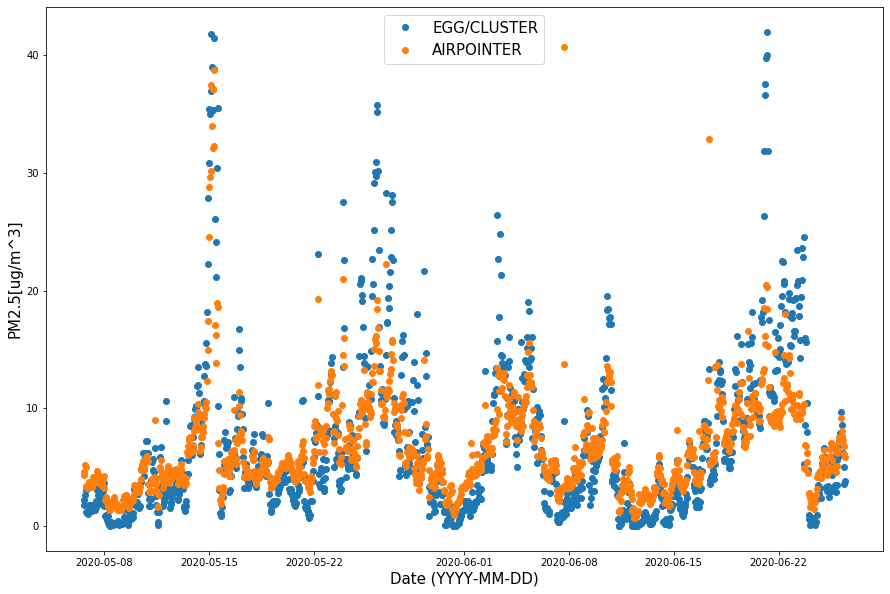

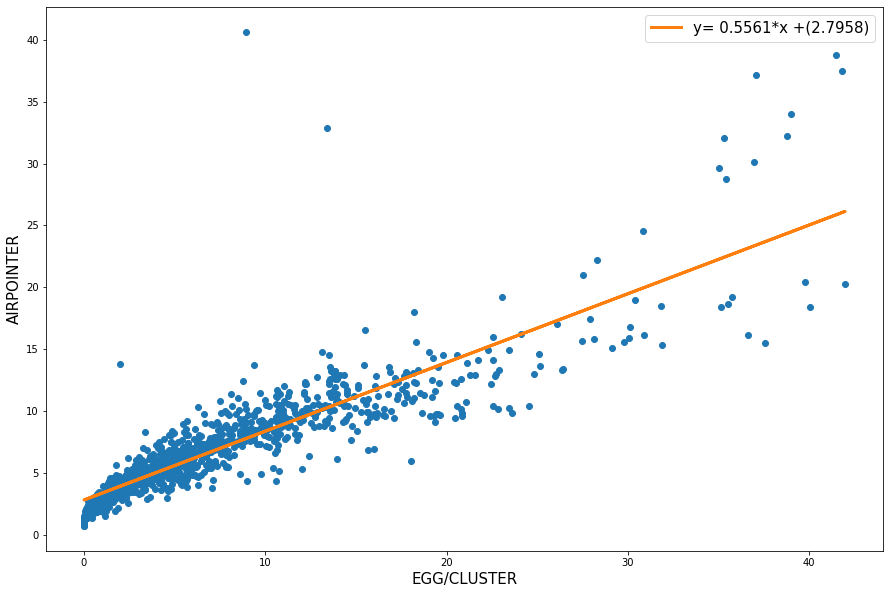

In [6]:
# ----------------------------- PM2.5 FROM CLUSTER vs. PM2.5 FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(dataframe.index.to_series(), dataframe['PM2.5[ug/m^3]'], 'o', label="EGG/CLUSTER")
plt.plot(dataframe.index.to_series(), dataframe['PM2.5_conc'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('PM2.5[ug/m^3]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = dataframe['PM2.5[ug/m^3]'].to_numpy()
# Airpointer
yValues = dataframe['PM2.5_conc'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

In [7]:
# Calculate the rate of change of the PM2.5[ug/m^3] measurement
ROC = []
for i in range(len(dataframe['PM2.5[ug/m^3]']) - 1):
    ROC.append(dataframe['PM2.5[ug/m^3]'][i+1] - dataframe['PM2.5[ug/m^3]'][i])
    
ROC.insert(0, None)
ROC = np.array(ROC, dtype=float).reshape(-1,1)
# ADD rate of change column to the dataset
dataframe['PM2.5_ROC'] = ROC
# Drop null values
dataframe = dataframe.dropna()
counter = 0
for item in dataframe['PM2.5_ROC']:
    if np.abs(item) > 2:
         dataframe.iloc[counter]['PM2.5[ug/m^3]'] = dataframe.iloc[counter]['PM2.5[ug/m^3]'] / 2
    counter = counter + 1

0.6220495575374145

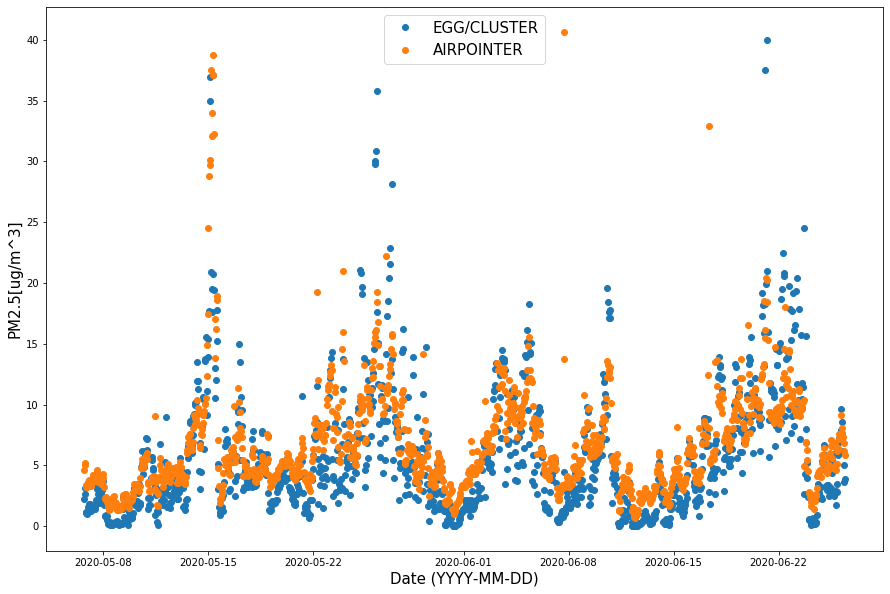

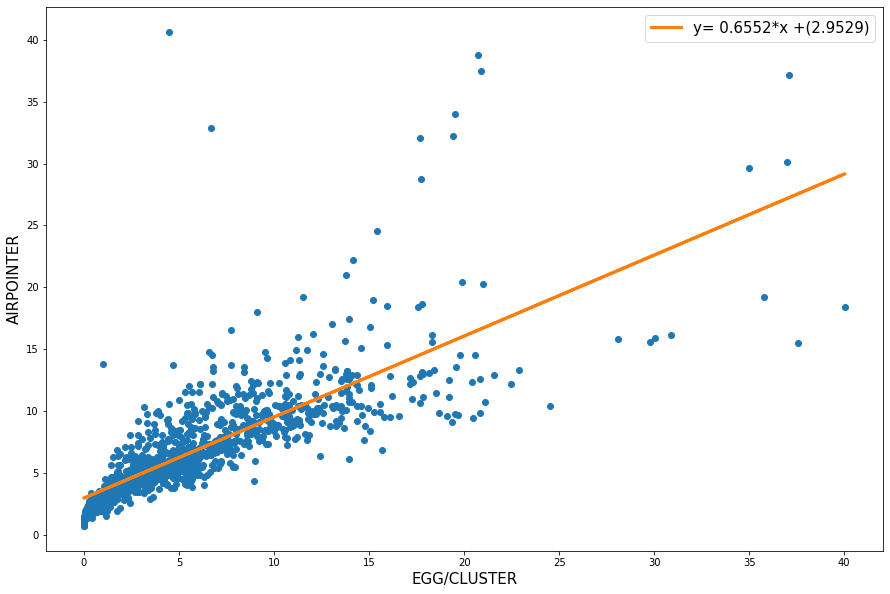

In [8]:
# ----------------------------- PM2.5 FROM CLUSTER vs. PM2.5 FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(dataframe.index.to_series(), dataframe['PM2.5[ug/m^3]'], 'o', label="EGG/CLUSTER")
plt.plot(dataframe.index.to_series(), dataframe['PM2.5_conc'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('PM2.5[ug/m^3]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = dataframe['PM2.5[ug/m^3]'].to_numpy()
# Airpointer
yValues = dataframe['PM2.5_conc'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

In [9]:
# ------------------------------------- BUILD TRAINING AND TEST SETS -------------------------------------
# Split the dataframe into TRAINING and TEST sets
# TRAINING DATA
training_data = drop_values(dataframe, dataframe.index, '2020-06-19 15:00:00', 0)
DATA_train_dataframe = training_data.drop(columns = ['NO2', 'NO', 'NOx', 'NO2[V]', 'O3[V]', 'Relative_Humidity', 'PM2.5_conc',
                                                     'PM10_conc_all', 'O3', 'Air_Temperature', 'PM10-2.5_conc', 'NO2[ppb]'])
DATA_train = norm(DATA_train_dataframe).to_numpy()
target_train = training_data['PM2.5_conc']
target_train = target_train.to_numpy()
# TESTING DATA
test_data = drop_values(dataframe, dataframe.index, '2020-06-19 16:00:00', 1)
DATA_test_dataframe = test_data.drop(columns = ['NO2', 'NO', 'NOx', 'NO2[V]', 'O3[V]', 'Relative_Humidity', 'PM2.5_conc',
                                                     'PM10_conc_all', 'O3', 'Air_Temperature', 'PM10-2.5_conc', 'NO2[ppb]'])
DATA_test = norm(DATA_test_dataframe).to_numpy()
target_test = test_data['PM2.5_conc']
target_test = target_test.to_numpy()

# --------------------------- TRAIN THE LINEAR REGRESSION MODEL ---------------------------
lr = LinearRegression().fit(DATA_train, target_train)
print("TRAINING PERFORMANCE:")
print("Training set score: {:0.6f}".format(lr.score(DATA_train, target_train)))
print('MAE: {:0.4f}\n'.format(metrics.mean_absolute_error(target_train, lr.predict(DATA_train))))
print("TEST PERFROMANCE:")
print("Training set score: {:0.6f}".format(lr.score(DATA_test, target_test)))
print('MAE: {:0.4f}\n'.format(metrics.mean_absolute_error(target_test, lr.predict(DATA_test))))
for i in range(len(DATA_train_dataframe.columns)):
    print("{}: {}".format(DATA_train_dataframe.columns[i], lr.coef_[i]))
print('\nIntercept: ', lr.intercept_)

TRAINING PERFORMANCE:
Training set score: 0.857598
MAE: 0.8893

TEST PERFROMANCE:
Training set score: 0.453831
MAE: 2.3956

Temperature[degC]: 0.5693912819831836
Humidity[percent]: -0.5171573246249832
PM1.0[ug/m^3]: -1.935003994778338
PM2.5[ug/m^3]: 0.18545669935089898
PM10.0[ug/m^3]: 5.896947624096177
O3[ppb]: -0.161720407950037
Pressure[Pa]: -0.0983585580321072
PM2.5_ROC: 0.06245777029156776

Intercept:  6.42480988593154


0.807914203114536

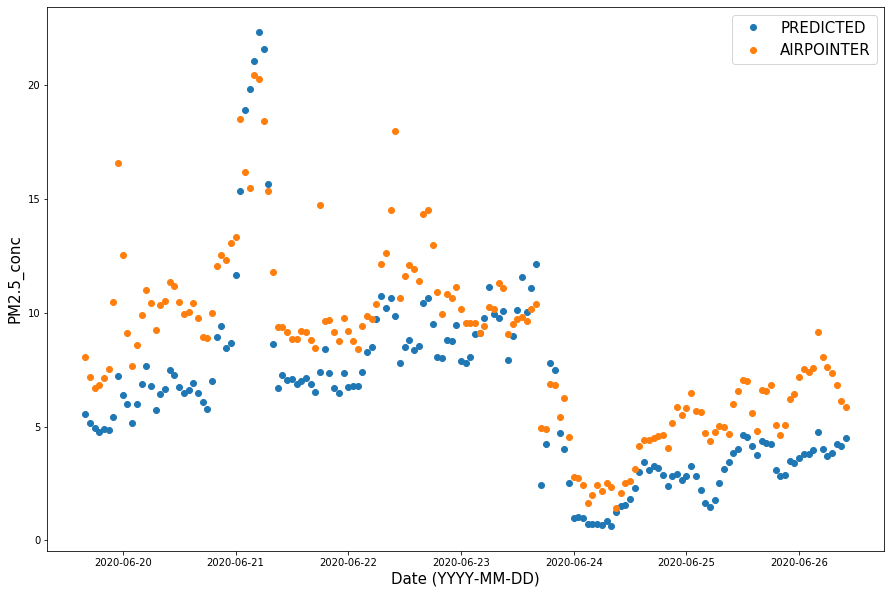

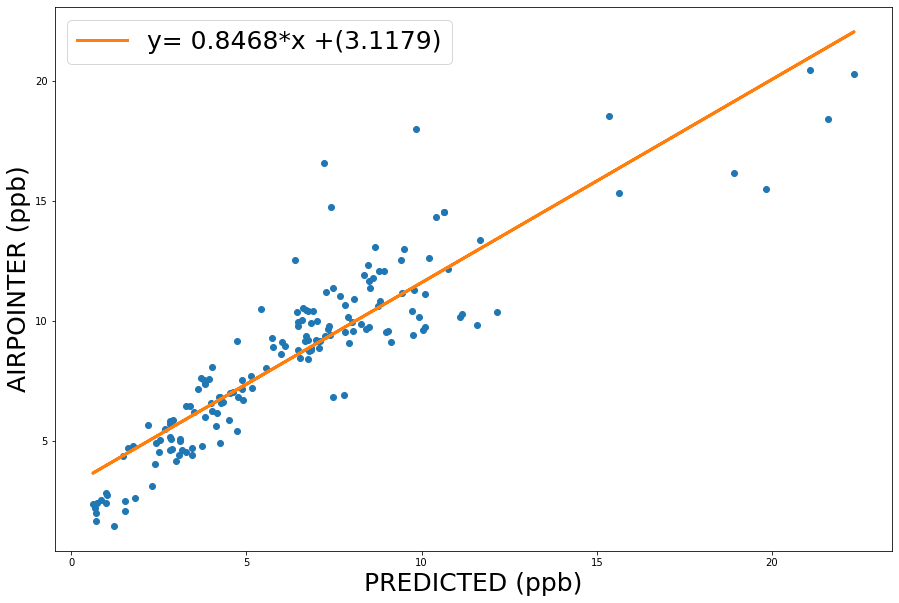

In [13]:
# Plot the time series graph
plt.figure(figsize=(15,10))
plt.plot(test_data.index.to_series(), lr.predict(DATA_test), 'o', label="PREDICTED")
plt.plot(test_data.index.to_series(), test_data['PM2.5_conc'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('PM2.5_conc', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
xValues = lr.predict(DATA_test)
yValues = test_data['PM2.5_conc'].to_numpy()
# Calculate a regression line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('PREDICTED (ppb)', fontsize=25)
plt.ylabel('AIRPOINTER (ppb)', fontsize=25)
plt.legend(loc='best', fontsize=25)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

0.605438225096139

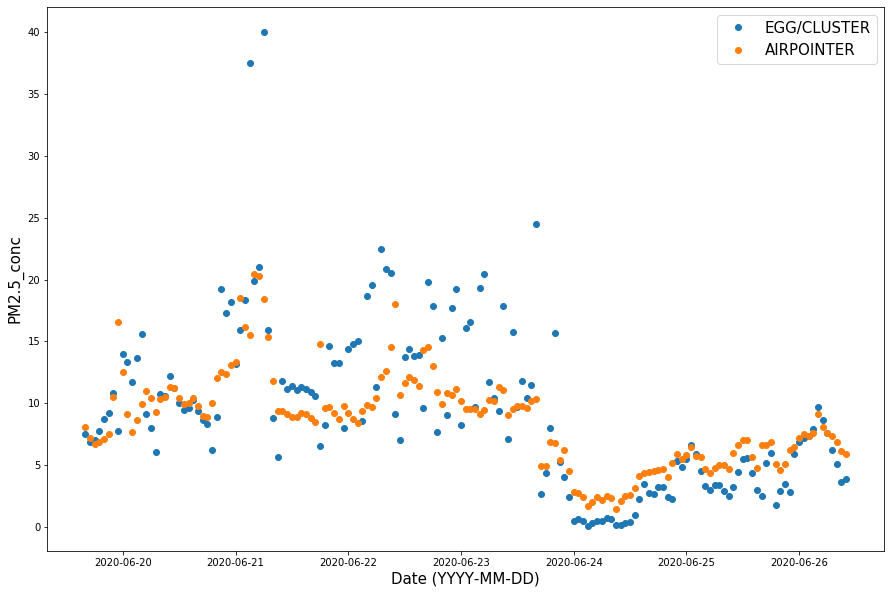

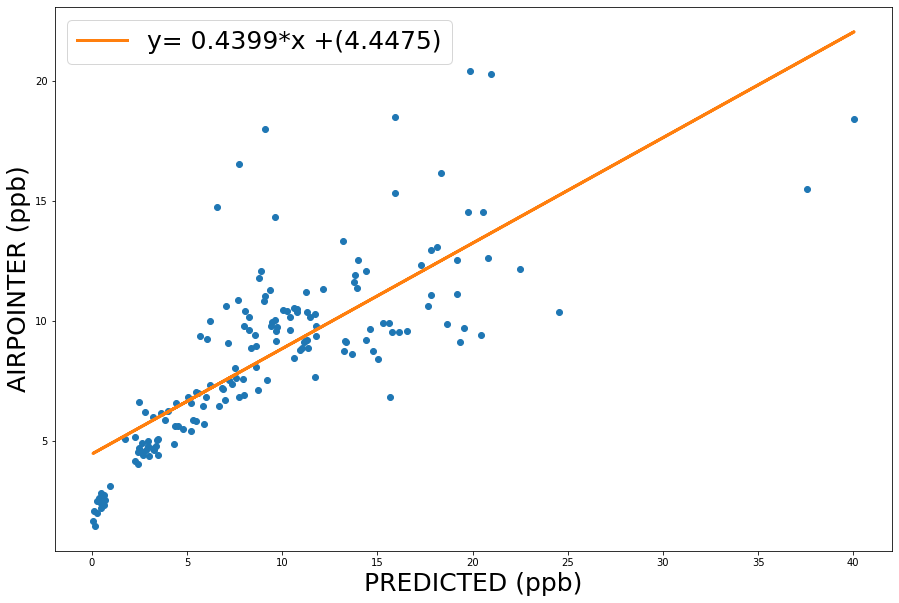

In [12]:
# Plot the time series graph
plt.figure(figsize=(15,10))
plt.plot(test_data.index.to_series(), test_data['PM2.5[ug/m^3]'], 'o', label='EGG/CLUSTER')
plt.plot(test_data.index.to_series(), test_data['PM2.5_conc'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('PM2.5_conc', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
xValues = test_data['PM2.5[ug/m^3]'].to_numpy()
yValues = test_data['PM2.5_conc'].to_numpy()
# Calculate a regression line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('PREDICTED (ppb)', fontsize=25)
plt.ylabel('AIRPOINTER (ppb)', fontsize=25)
plt.legend(loc='best', fontsize=25)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))